# Rhyolitic glasses from Mallik et al. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set up to find custom python package
import os
import sys
import numpy as np
sys.path.insert(1, ".")
sys.path.insert(1, "..")

In [3]:
from src import readfiles, wdscan, correct_quant, calczaf, helper_funs
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from nb_helper_funs import compile_n_summary

np.random.seed(42)

# Nitrogen analyses

### WD scan - visualise & fit

In [4]:
samplenames = ["A870", "A876", "B989"]
metadata_list = {}
data_list = {}

for s in samplenames:
    print(f"---------------- {s} ----------------")

    folderpath = f"../data/raw/rhyolitic_glasses_StA/{s}_long_scan"
    
    # Read in the data
    for d in ["data001", "data002"]:
        try:             
            comments, data, metadata = readfiles.import_jeol_wdscans(
                subfolder=folderpath,
                scan_filename=f'{d}_mm.csv',
                cnd_filename=f'{d}.cnd',
                comment_line_num=80,
                crystal_line_name="$XM_WDS_CRYSTAL_NAME%0",
                sep=',',
                return_metadata=True
            )

            metadata_list[s] = metadata
            data_list[s] = data
        except FileNotFoundError:
                print(f"No file found for {d}")


---------------- A870 ----------------
No file found for data002
---------------- A876 ----------------
No file found for data002
---------------- B989 ----------------
No file found for data002


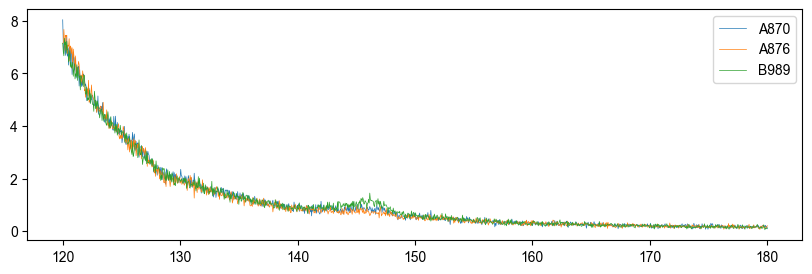

In [5]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 3))
ax.plot(data_list["A870"].L, data_list["A870"].cps_per_nA, label="A870", lw=0.5)
ax.plot(data_list["A876"].L, data_list["A876"].cps_per_nA, label="A876", lw=0.5)
ax.plot(data_list["B989"].L, data_list["B989"].cps_per_nA, label="B989", lw=0.5)
plt.legend()


These are all very similar. I think I could fit them all together and then treat these
three glasses as a 'group' of samples. Maybe just aggregate the 146.6 and 146.4 versions too.

In [6]:
result, trimmed_data = wdscan.fit_scans_together(
    data = list(data_list.values()),
    fit_regions = [[120, 140], [152, 180]],
    path_out = Path("../data/interim/rhyolitic_glasses/fits")
)

Performing the fit...
Saved fit parameters to ..\data\interim\rhyolitic_glasses\fits


Saved figure showing fit to A870 in folder "..\data\interim\rhyolitic_glasses\fits"
Saved figure showing fit to A876 in folder "..\data\interim\rhyolitic_glasses\fits"
Saved figure showing fit to B989 in folder "..\data\interim\rhyolitic_glasses\fits"


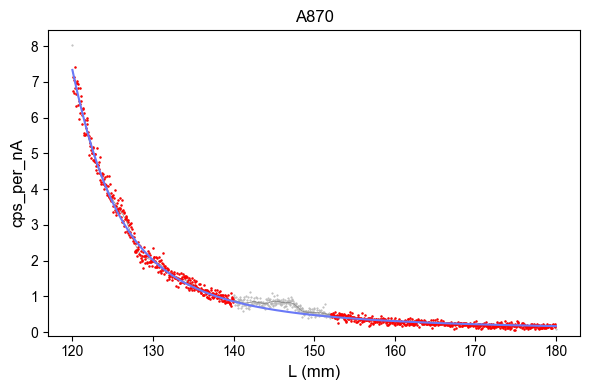

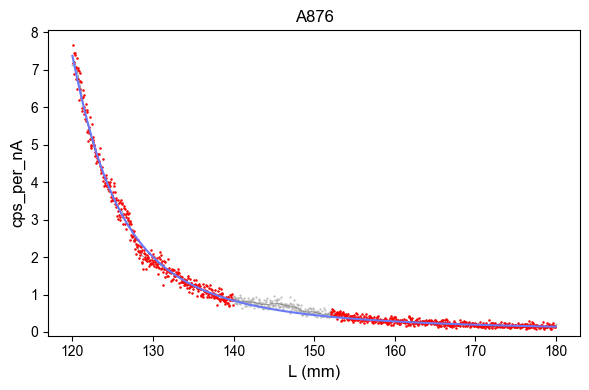

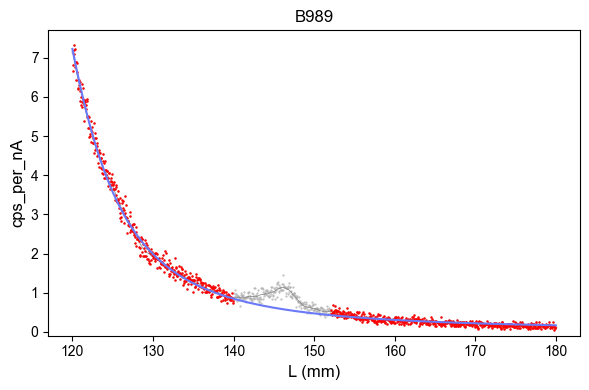

In [7]:
wdscan.plot_fits_together(
    data=list(data_list.values()),
    trimmed_data=trimmed_data,
    result=result,
    comments=list(data_list.keys()),
    path_out=Path("../data/interim/rhyolitic_glasses/fits")
    )

Those fits look good!

# Quant analysis

In [8]:
sample_list = ['A870', 'A876', 'B989']
sample_folders = [Path(f'../data/raw/rhyolitic_glasses_StA/quant/{s}/') for s in sample_list]
# List of folders corresponding to the samples
category = 'rhyolitic glasses' # Category of this dataset (e.g. "glasses")
wd_scan = Path(f'../data/interim/rhyolitic_glasses/fits/key_params.txt') # Path to wd scan fit parameters
std_dbase_info_file = Path('data/_dictionaries/standards.csv')

In [9]:
datalist = readfiles.find_files_and_folders(
                sample_list, sample_folders,
                # apf_file = None,
                apf_file=Path('../data/_dictionaries/apf_values.csv'), #<- Can put None in here
                wd_scan=wd_scan
                )

datalist

Comments found: ['A870_50nA_20um_146.4_spot-4', 'A870_50nA_20um_146.4_spot-5', 'A870_50nA_20um_146.4_spot-6', 'A870_50nA_20um_146.6_spot-1', 'A870_50nA_20um_146.6_spot-2', 'A870_50nA_20um_146.6_spot-3', 'A870_50nA_20um_146.6_spot-4', 'A870_50nA_20um_146.6_spot-5']
Comments found: ['A876_50nA_20um_146.4_spot-1', 'A876_50nA_20um_146.4_spot-2', 'A876_50nA_20um_146.4_spot-3', 'A876_50nA_20um_146.4_spot-4', 'A876_50nA_20um_146.4_spot-5', 'A876_50nA_20um_146.4_spot-6']
Comments found: ['B989_50nA_20um_146.4_spot-1', 'B989_50nA_20um_146.4_spot-2', 'B989_50nA_20um_146.4_spot-3', 'B989_50nA_20um_146.4_spot-4', 'B989_50nA_20um_146.4_spot-5', 'B989_50nA_20um_146.4_spot-6']


,folder,comment,sample,paramfile,apf,apf_sd
0,..\data\raw\rhyolitic_glasses_StA\quant\A870\A...,A870_50nA_20um_146.4_spot-4,A870,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03
1,..\data\raw\rhyolitic_glasses_StA\quant\A870\A...,A870_50nA_20um_146.4_spot-5,A870,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03
2,..\data\raw\rhyolitic_glasses_StA\quant\A870\A...,A870_50nA_20um_146.4_spot-6,A870,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03
3,..\data\raw\rhyolitic_glasses_StA\quant\A870\A...,A870_50nA_20um_146.6_spot-1,A870,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03
4,..\data\raw\rhyolitic_glasses_StA\quant\A870\A...,A870_50nA_20um_146.6_spot-2,A870,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03
5,..\data\raw\rhyolitic_glasses_StA\quant\A870\A...,A870_50nA_20um_146.6_spot-3,A870,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03
6,..\data\raw\rhyolitic_glasses_StA\quant\A870\A...,A870_50nA_20um_146.6_spot-4,A870,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03
7,..\data\raw\rhyolitic_glasses_StA\quant\A870\A...,A870_50nA_20um_146.6_spot-5,A870,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03
8,..\data\raw\rhyolitic_glasses_StA\quant\A876\A...,A876_50nA_20um_146.4_spot-1,A876,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03
9,..\data\raw\rhyolitic_glasses_StA\quant\A876\A...,A876_50nA_20um_146.4_spot-2,A876,..\data\interim\rhyolitic_glasses\fits\key_par...,0.83,0.03


In [10]:
myspot = [None] * len(datalist.folder)

for i in range(len(datalist.folder)):
    peak, bg, standard, info = readfiles.read_and_organise_data(
                                    datalist.loc[i,:].copy(),
                                    bgi=False,
                                    save=False)
    myspot[i] = correct_quant.Spot()
    myspot[i].add_data(info, bg, peak, standard)
    myspot[i].add_wd_scan_params_from_file(wd_scan)
    print('Read dataset:', i + 1, 'of', len(datalist), ':',
          myspot[i].info.comment)
    myspot[i].comprehensify_data()


 loading path: ..\data\interim\rhyolitic_glasses\fits\key_params.txt
{'sigma': 6.833751656078774, 'center': 114.17526032389036}
Read dataset: 1 of 20 : A870_50nA_20um_146.4_spot-4

 loading path: ..\data\interim\rhyolitic_glasses\fits\key_params.txt
{'sigma': 6.833751656078774, 'center': 114.17526032389036}
Read dataset: 2 of 20 : A870_50nA_20um_146.4_spot-5

 loading path: ..\data\interim\rhyolitic_glasses\fits\key_params.txt
{'sigma': 6.833751656078774, 'center': 114.17526032389036}
Read dataset: 3 of 20 : A870_50nA_20um_146.4_spot-6

 loading path: ..\data\interim\rhyolitic_glasses\fits\key_params.txt
{'sigma': 6.833751656078774, 'center': 114.17526032389036}
Read dataset: 4 of 20 : A870_50nA_20um_146.6_spot-1

 loading path: ..\data\interim\rhyolitic_glasses\fits\key_params.txt
{'sigma': 6.833751656078774, 'center': 114.17526032389036}
Read dataset: 5 of 20 : A870_50nA_20um_146.6_spot-2

 loading path: ..\data\interim\rhyolitic_glasses\fits\key_params.txt
{'sigma': 6.8337516560787

In [11]:
correct_quant.process_datasets(
    myspot, 
    datalist, 
    num_mc_sims=100, 
    path_out=Path(f"../data/processed/rhyolitic_glasses/background_corrections")
    )


Processing dataset: 1 of 20 : A870_50nA_20um_146.4_spot-4
Correcting background
Saved bg correction figure for 2021-11-15_A870_50nA_20um_146-4_spot-4
Resample cps to check stdev method
Montecarlo background correction
monte-carlo loop 0 of 100
monte-carlo loop 50 of 100
Saved montecarlo bg correction figure for 2021-11-15_A870_50nA_20um_146.4_spot-4
correct height/area ratio
original kraw: 3.38 ± 4.96%
corrected kraw: 6.96 ± 4.52%

Processing dataset: 2 of 20 : A870_50nA_20um_146.4_spot-5
Correcting background
Saved bg correction figure for 2021-11-15_A870_50nA_20um_146-4_spot-5
Resample cps to check stdev method
Montecarlo background correction
monte-carlo loop 0 of 100
monte-carlo loop 50 of 100
Saved montecarlo bg correction figure for 2021-11-15_A870_50nA_20um_146.4_spot-5
correct height/area ratio
original kraw: 3.16 ± 5.22%
corrected kraw: 6.60 ± 4.28%

Processing dataset: 3 of 20 : A870_50nA_20um_146.4_spot-6
Correcting background
Saved bg correction figure for 2021-11-15_A870_

## Write calczaf files

In [12]:
samples = sample_list
subfolder = Path(f'../data/processed/rhyolitic_glasses/calczaf_files/')

write_detection_limit_calczaf_files = True
detlim_subfolder = subfolder / Path('detlim')

# note: in the subfolder there must be a file specifying valence.
# this can be copied from the _dictionaries folder.
valence_dict = readfiles.read_valence_file(subfolder, pattern='valence*')
standard_database_dict = pd.read_csv(
    '../data/_dictionaries/standards.csv',
     index_col=0, 
     header=None, 
     squeeze=True).to_dict()

standard_database_dict

{'Sanidine': 3000,
 'Diopside': 3001,
 '08_Pollucite': 3002,
 'Albite': 3003,
 'GaN': 608,
 '22_Mo': 542,
 '09_Vanadium_Wire_Alfa': 523,
 'BN': 604}

In [13]:
myspot

In [14]:
# Make a dictionary
# Separate the myspot list by sample
sampledata = [None]*len(samples)
for i, sample in enumerate(samples):
    sampledata[i] = [spot for i, spot in enumerate(myspot) if sample == spot.info['sample']]

sampledata = dict(zip(samples,sampledata))

For these glasses we did not do major element analyses, so we need to use
literature values

In [15]:
B989_majors = pd.DataFrame.from_dict(dict(
    SiO2 = [67.9, 0.2],
    TiO2 = [0.22, 0.3],
    Al2O3 = [13.58, 0.09],
    FeO = [0.01, 0.01],
    MnO = [0.01, 0.01],
    MgO = [0.25, 0.02],
    CaO = [1.10, 0.04],
    Na2O = [6.0, 0.1],
    K2O = [2.40, 0.05],
    P2O5 = [0.06, 0.04]
), orient="index", columns=["wt%", "stdev"])

A870_majors = pd.DataFrame.from_dict(dict(
    SiO2 = [64.3, 0.3],
    TiO2 = [0.21, 0.2],
    Al2O3 = [13.8, 0.1],
    FeO = [0.03, 0.02],
    MnO = [0.03, 0.02],
    MgO = [0.26, 0.02],
    CaO = [1.07, 0.04],
    Na2O = [5.45, 0.1],
    K2O = [2.38, 0.04],
    P2O5 = [0.05, 0.03]
), orient="index", columns=["wt%", "stdev"])

A876_majors = pd.DataFrame.from_dict(dict(
    SiO2 = [63.4, 0.8],
    TiO2 = [0.23, 0.3],
    Al2O3 = [13.78, 0.01],
    FeO = [0.01, 0.01],
    MnO = [0.01, 0.01],
    MgO = [0.26, 0.02],
    CaO = [1.06, 0.03],
    Na2O = [5.4, 0.4],
    K2O = [2.39, 0.05],
    P2O5 = [0.03, 0.02]
), orient="index", columns=["wt%", "stdev"])

majors_relevant_oxide = dict(zip(["A870", "A876", "B989"], [A870_majors, A876_majors, B989_majors]))

In [16]:
import pyrolite.geochem

2024-11-10 18:57:32,338 pyrolite.util.plot.helpers - WARNING: scikit-learn not installed


In [17]:
majors_relevant = {
    k: v[["wt%"]].T[["SiO2", "TiO2", "Al2O3", "FeO", "MnO", "MgO", "CaO", "Na2O", "K2O", "P2O5"]]
    .pyrochem.convert_chemistry(
        to=["Si", "Ti", "Al", "Fe", "Mn", "Mg", "Ca", "Na", "K", "P"]
    )
    .T.squeeze()
    for k, v in majors_relevant_oxide.items()
}

In [18]:
majors_relevant["B989"]

Si    31.738831
Ti     0.131855
Al     7.187224
Fe     0.007773
Mn     0.007745
Mg     0.150759
Ca     0.786160
Na     4.451145
K      1.992355
P      0.026185
Name: wt%, dtype: float64

In [19]:
# For multiple different methods of processing the data, add a description
run_descriptor = ['_1_base', '_2_bg', '_3_bg_apf']  
# Leave as a list of an empty string if not using: e.g. run_descriptor = ['']

for i in range(len(samples)):

    # Here we pass in these arguments as a dictionary - this is useful in order
    # to reuse the arguments for the detection limit function. But you can
    # alternatively pass in each argument just by defining it in the function
    # as normal (see glasses example).

    args = {
              'elementByDifference' : 'h' # string element symbol
            , 'elementByStoichToStoichOxygen' : None # string element symbol
            , 'stoichOxygenRatio' : 0
            # for hyalophane there is H
            # that can be defined stoichiometrically relative to N:
            , 'elementByStoichToOtherElement' : None
            , 'OtherElement' : None
            , 'stoichElementRatio' : None

            , 'correct_bg' : False
            , 'correct_apf' : False

            # Elements to omit from matrix correction
            # (e.g. if analysed but not actually present in sample)
            , 'remove_elements' : None

            , 'definedElements' : majors_relevant[samples[i]].index # list of element symbols to add
            , 'definedElementWts' : majors_relevant[samples[i]].values # list of known element wt% to add
            }
    
    # Make copies of args with different values
    args2 = args.copy()
    args2["correct_bg"] = True
    args2["correct_apf"] = False

    args3 = args2.copy()
    args3["correct_bg"] = True
    args3["correct_apf"] = True

    args_list = [args, args2, args3]

    for j in range(len(run_descriptor)):
        print("******************************************************")
        print(args_list[j]["correct_bg"], args_list[j]["correct_apf"])
        print("******************************************************")

        calczaf_path_out = subfolder / '{}{}.dat'.format(
                                            samples[i], run_descriptor[j])
        open(calczaf_path_out, 'w').close()  # Erase contents of file

        if write_detection_limit_calczaf_files:
            
            detlim_path_out = detlim_subfolder / '{}{}_detlim.dat'.format(
                                            samples[i], run_descriptor[j])
            open(detlim_path_out, 'w').close()  # Erase contents of file

        for spot in sampledata[samples[i]]:

            calczaf.write_calczaf_input(
                spot, calczaf_path_out, valence_dict, standard_database_dict,
                accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                **args_list[j]) # <- **args unpacks the args dictionary defined earlier
                # so that all those arguments are passed into the function
                # without the need to type them all out.

            if write_detection_limit_calczaf_files:
                if args_list[j]['correct_bg']:

                    detlim_spot = correct_quant.create_detection_limit_spot(spot)

                    calczaf.write_calczaf_input(
                        detlim_spot, detlim_path_out, valence_dict, 
                        standard_database_dict,
                        accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                        **args_list[j])
                    
                else:
                    print('\n\nWarning: Not writing detection limit file.' 
                            'Calculating detection limit does not make sense'
                            ' except on background-corrected data. Raw data files' 
                            ' contain an estimate of detection limit without bg'
                            ' correction.\n')
                    
    

******************************************************
False False
******************************************************
Wrote CALCZAF file for A870_50nA_20um_146.4_spot-4 to ..\data\processed\rhyolitic_glasses\calczaf_files\A870_1_base.dat



Wrote CALCZAF file for A870_50nA_20um_146.4_spot-5 to ..\data\processed\rhyolitic_glasses\calczaf_files\A870_1_base.dat



Wrote CALCZAF file for A870_50nA_20um_146.4_spot-6 to ..\data\processed\rhyolitic_glasses\calczaf_files\A870_1_base.dat



Wrote CALCZAF file for A870_50nA_20um_146.6_spot-1 to ..\data\processed\rhyolitic_glasses\calczaf_files\A870_1_base.dat



Wrote CALCZAF file for A870_50nA_20um_146.6_spot-2 to ..\data\processed\rhyolitic_glasses\calczaf_files\A870_1_base.dat



Wrote CALCZAF file for A870_50nA_20um_146.6_spot-3 to ..\data\processed\rhyolitic_glasses\calczaf_files\A870_1_base.dat



Wrote CALCZAF file for A870_50nA_20um_146.6_spot-4 to ..\data\processed\rhyolitic_glasses\calczaf_files\A870_1_base.dat



Wrote CALCZAF fil

# Manual step: run through calczaf

- Use default MAC table (LINEMU)
- Use XPP matrix correction method

# Process calczaf outputs

In [20]:
folderpath = Path(f'../data/processed/rhyolitic_glasses/calczaf_files/')

helper_funs.check_calczaf_folder_exists(folderpath)
valence_file = sorted(folderpath.glob('valence*'))[0]

results = calczaf.process_calczaf_outputs(folderpath, valence_file)

# For detection limits

results_detlim = calczaf.process_calczaf_outputs(folderpath / 'detlim/', valence_file, detlim=True)

[                      0           1           2           3           4           5           6           7
wt% element                                                                                                
Si            30.056100   30.056100   30.056100   30.056100   30.056100   30.056100   30.056100   30.056100
Al             7.303660    7.303660    7.303660    7.303660    7.303660    7.303660    7.303660    7.303660
Ca             0.764719    0.764719    0.764719    0.764719    0.764719    0.764719    0.764719    0.764719
Mg             0.156789    0.156789    0.156789    0.156789    0.156789    0.156789    0.156789    0.156789
Fe             0.023319    0.023319    0.023319    0.023319    0.023319    0.023319    0.023319    0.023319
Mn             0.023234    0.023234    0.023234    0.023234    0.023234    0.023234    0.023234    0.023234
Ti             0.125862    0.125862    0.125862    0.125862    0.125862    0.125862    0.125862    0.125862
K              1.975750    

In [21]:
summary_tables = {}
typical_kratios = {}

for s in samples:
    summary_tables[s] = correct_quant.write_summary_excel_tables(
        sampledata[s], 
        f"../data/processed/rhyolitic_glasses/kraw_summaries_{s}.xlsx"
        )
    
    typical_kratios[s] = pd.DataFrame({
        "K-ratio": [
            summary_tables[s][0]["original.kraw_pcnt"].mean(),
            summary_tables[s][0]["montecarlo.kraw_pcnt"].mean(),
            summary_tables[s][0]["montecarlo.kraw_apf_pcnt"].mean()
        ],
        "Stdev % (relative)": [
            max(
                summary_tables[s][0]["original.kraw_stdev_pcnt"].mean(),
                summary_tables[s][0]["original.kraw_pcnt"].std()
                ),
            max(
                summary_tables[s][0]["montecarlo.kraw_stdev_pcnt"].mean(),
                summary_tables[s][0]["montecarlo.kraw_pcnt"].std()
                ),
            max(
                summary_tables[s][0]["montecarlo.kraw_stdev_apf_pcnt"].mean(),
                summary_tables[s][0]["montecarlo.kraw_apf_pcnt"].std()
                )
        ]
    }, index = [
        "Original K-ratio (%)", 
        "Bg-corrected K-ratio (%)", 
        "Bg- and APF-corrected K-ratio (%)"
        ]
    )

    typical_kratios[s].insert(
        1, 
        column="Stdev (absolute)", 
        value = typical_kratios[s]["K-ratio"] * typical_kratios[s]["Stdev % (relative)"] / 100
        )
    
    typical_kratios[s]["filename"] = [k for k in results["wtdata"].keys() if s in k]
    typical_kratios[s].reset_index(inplace=True)
    typical_kratios[s].set_index("filename", inplace=True)


In [22]:
typical_kratios


{'A870':                                            index  K-ratio  Stdev (absolute)  Stdev % (relative)
 filename                                                                                       
 A870_1_base                 Original K-ratio (%)  3.20750          0.164825             5.13875
 A870_2_bg               Bg-corrected K-ratio (%)  5.47750          0.140909             2.57250
 A870_3_bg_apf  Bg- and APF-corrected K-ratio (%)  6.59875          0.293067             4.44125,
 'A876':                                            index   K-ratio  Stdev (absolute)  Stdev % (relative)
 filename                                                                                        
 A876_1_base                 Original K-ratio (%)  1.268333          0.610026           48.096667
 A876_2_bg               Bg-corrected K-ratio (%)  3.490000          0.128083            3.670000
 A876_3_bg_apf  Bg- and APF-corrected K-ratio (%)  4.203333          0.217382            5.171667,
 'B989'

Plot all spots grouped by their method

In [23]:
suffix = "3_bg_apf"
stdev_string = "kraw_stdev_apf_pcnt"

In [24]:
results_apf = {k: v.loc["N", :] for k, v in results["wtdata"].items() if suffix in k}
results_detlim_apf = {k: v.loc["N", :] for k, v in results_detlim["wtdata"].items() if suffix in k}

results_apf = {
    k: v.loc[
        [c for c in v.index if c not in ["average", "stdev", "minimum", "maximum"]]
    ]
    for k, v in results_apf.items()
}

results_detlim_apf = {
    k: v.loc[
        [c for c in v.index if c not in ["average", "stdev", "minimum", "maximum"]]
    ]
    for k, v in results_detlim_apf.items()
}

for k, v in results_apf.items():
    v.name = "N wt"

for k, v in results_detlim_apf.items():
    v.name = "N detlim"


In [25]:
datalist_by_sample= dict(list(datalist.groupby("sample")))

In [26]:
N_by_method = {}
for s in samples:
    N_by_method[s] = pd.DataFrame(
        {
            "comment": datalist_by_sample[s]["comment"].reset_index(drop=True),
            "N wt": results_apf[f"{s}_3_bg_apf"],
            "N detlim": results_detlim_apf[f"{s}_3_bg_apf_detlim"],
            "N stdev pct": summary_tables[s][0][f"montecarlo.{stdev_string}"],
            "N stdev abs": (
                results_apf[f"{s}_3_bg_apf"]
                * summary_tables[s][0][f"montecarlo.{stdev_string}"]
                / 100
            )
        }
    )

In [27]:
for s in samples:
    display(N_by_method[s])

,comment,N wt,N detlim,N stdev pct,N stdev abs
0,A870_50nA_20um_146.4_spot-4,1.20552,0.039725,4.52,0.054490
1,A870_50nA_20um_146.4_spot-5,1.14316,0.019533,4.28,0.048927
2,A870_50nA_20um_146.4_spot-6,1.10749,0.024455,4.63,0.051277
3,A870_50nA_20um_146.6_spot-1,1.05964,0.021501,4.62,0.048955
4,A870_50nA_20um_146.6_spot-2,1.13254,0.025026,4.38,0.049605
5,A870_50nA_20um_146.6_spot-3,1.15412,0.021661,4.27,0.049281
6,A870_50nA_20um_146.6_spot-4,1.16682,0.021356,4.47,0.052157
7,A870_50nA_20um_146.6_spot-5,1.17161,0.025126,4.36,0.051082


,comment,N wt,N detlim,N stdev pct,N stdev abs
0,A876_50nA_20um_146.4_spot-1,0.789392,0.020842,4.62,0.036470
1,A876_50nA_20um_146.4_spot-2,0.817747,0.038789,5.08,0.041542
2,A876_50nA_20um_146.4_spot-3,0.720249,0.019179,5.41,0.038965
3,A876_50nA_20um_146.4_spot-4,0.821902,0.021434,4.98,0.040931
4,A876_50nA_20um_146.4_spot-5,0.714137,0.018802,4.81,0.034350
5,A876_50nA_20um_146.4_spot-6,0.484801,0.034979,6.13,0.029718


,comment,N wt,N detlim,N stdev pct,N stdev abs
0,B989_50nA_20um_146.4_spot-1,1.26734,0.020637,4.29,0.054369
1,B989_50nA_20um_146.4_spot-2,1.23050,0.037629,4.46,0.054880
2,B989_50nA_20um_146.4_spot-3,1.24568,0.034965,4.35,0.054187
3,B989_50nA_20um_146.4_spot-4,1.28193,0.021655,4.32,0.055379
4,B989_50nA_20um_146.4_spot-5,1.26301,0.020791,4.24,0.053552
5,B989_50nA_20um_146.4_spot-6,1.31426,0.028024,4.26,0.055987


In [28]:
summary_tables = correct_quant.write_summary_excel_tables(
        myspot, 
        f"../data/processed/rhyolitic_glasses/kraw_summaries_all.xlsx"
        )

suffix_list = ["1_base", "2_bg", "3_bg_apf"]

summary, details = compile_n_summary(
    suffix_list, results, results_detlim, sampledata, datalist, summary_tables, samples
)

summary

Sample: A870, suffix: 1_base


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,A870,A870_50nA_20um_146.4_spot-4,0.585726,4.96,0.029052,NaN,0.0257
1,A870,A870_50nA_20um_146.4_spot-5,0.547107,5.22,0.028559,NaN,0.0254
2,A870,A870_50nA_20um_146.4_spot-6,0.526325,5.41,0.028474,NaN,0.0254
3,A870,A870_50nA_20um_146.6_spot-1,0.491860,5.68,0.027938,NaN,0.0250
4,A870,A870_50nA_20um_146.6_spot-2,0.549878,5.16,0.028374,NaN,0.0252
5,A870,A870_50nA_20um_146.6_spot-3,0.572738,4.96,0.028408,NaN,0.0251
6,A870,A870_50nA_20um_146.6_spot-4,0.586419,4.87,0.028559,NaN,0.0251
7,A870,A870_50nA_20um_146.6_spot-5,0.584860,4.85,0.028366,NaN,0.0249


Sample: A876, suffix: 1_base


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,A876,A876_50nA_20um_146.4_spot-1,0.293091,9.03,0.026466,NaN,0.0248
1,A876,A876_50nA_20um_146.4_spot-2,0.274302,9.83,0.026964,NaN,0.0254
2,A876,A876_50nA_20um_146.4_spot-3,0.207761,12.68,0.026344,NaN,0.0251
3,A876,A876_50nA_20um_146.4_spot-4,0.296538,9.07,0.026896,NaN,0.0252
4,A876,A876_50nA_20um_146.4_spot-5,0.231551,11.22,0.025980,NaN,0.0246
5,A876,A876_50nA_20um_146.4_spot-6,0.010691,236.75,0.025311,NaN,0.0251


Sample: B989, suffix: 1_base


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,B989,B989_50nA_20um_146.4_spot-1,0.647437,4.55,0.029458,NaN,0.0252
1,B989,B989_50nA_20um_146.4_spot-2,0.603973,4.88,0.029474,NaN,0.0254
2,B989,B989_50nA_20um_146.4_spot-3,0.629239,4.67,0.029385,NaN,0.0252
3,B989,B989_50nA_20um_146.4_spot-4,0.670051,4.40,0.029482,NaN,0.0251
4,B989,B989_50nA_20um_146.4_spot-5,0.656271,4.48,0.029401,NaN,0.0251
5,B989,B989_50nA_20um_146.4_spot-6,0.687718,4.32,0.029709,NaN,0.0252


Sample: A870, suffix: 2_bg


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,A870,A870_50nA_20um_146.4_spot-4,1.000710,2.71,0.027119,0.032972,0.0257
1,A870,A870_50nA_20um_146.4_spot-5,0.948948,2.28,0.021636,0.016212,0.0254
2,A870,A870_50nA_20um_146.4_spot-6,0.919334,2.89,0.026569,0.020298,0.0254
3,A870,A870_50nA_20um_146.6_spot-1,0.879607,2.87,0.025245,0.017846,0.0250
4,A870,A870_50nA_20um_146.6_spot-2,0.940124,2.48,0.023315,0.020772,0.0252
5,A870,A870_50nA_20um_146.6_spot-3,0.958048,2.28,0.021843,0.017978,0.0251
6,A870,A870_50nA_20um_146.6_spot-4,0.968591,2.63,0.025474,0.017725,0.0251
7,A870,A870_50nA_20um_146.6_spot-5,0.972561,2.44,0.023730,0.020855,0.0249


Sample: A876, suffix: 2_bg


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,A876,A876_50nA_20um_146.4_spot-1,0.655254,2.88,0.018871,0.017299,0.0248
1,A876,A876_50nA_20um_146.4_spot-2,0.678793,3.57,0.024233,0.032195,0.0254
2,A876,A876_50nA_20um_146.4_spot-3,0.597855,4.02,0.024034,0.015919,0.0251
3,A876,A876_50nA_20um_146.4_spot-4,0.682242,3.42,0.023333,0.017791,0.0252
4,A876,A876_50nA_20um_146.4_spot-5,0.592782,3.18,0.018850,0.015606,0.0246
5,A876,A876_50nA_20um_146.4_spot-6,0.402407,4.95,0.019919,0.029033,0.0251


Sample: B989, suffix: 2_bg


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,B989,B989_50nA_20um_146.4_spot-1,1.05204,2.32,0.024407,0.017129,0.0252
1,B989,B989_50nA_20um_146.4_spot-2,1.02145,2.61,0.026660,0.031232,0.0254
2,B989,B989_50nA_20um_146.4_spot-3,1.03405,2.42,0.025024,0.029021,0.0252
3,B989,B989_50nA_20um_146.4_spot-4,1.06415,2.36,0.025114,0.017973,0.0251
4,B989,B989_50nA_20um_146.4_spot-5,1.04844,2.23,0.023380,0.017257,0.0251
5,B989,B989_50nA_20um_146.4_spot-6,1.09099,2.26,0.024656,0.023260,0.0252


Sample: A870, suffix: 3_bg_apf


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,A870,A870_50nA_20um_146.4_spot-4,1.20552,4.52,0.054490,0.039725,0.0257
1,A870,A870_50nA_20um_146.4_spot-5,1.14316,4.28,0.048927,0.019533,0.0254
2,A870,A870_50nA_20um_146.4_spot-6,1.10749,4.63,0.051277,0.024455,0.0254
3,A870,A870_50nA_20um_146.6_spot-1,1.05964,4.62,0.048955,0.021501,0.0250
4,A870,A870_50nA_20um_146.6_spot-2,1.13254,4.38,0.049605,0.025026,0.0252
5,A870,A870_50nA_20um_146.6_spot-3,1.15412,4.27,0.049281,0.021661,0.0251
6,A870,A870_50nA_20um_146.6_spot-4,1.16682,4.47,0.052157,0.021356,0.0251
7,A870,A870_50nA_20um_146.6_spot-5,1.17161,4.36,0.051082,0.025126,0.0249


Sample: A876, suffix: 3_bg_apf


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,A876,A876_50nA_20um_146.4_spot-1,0.789392,4.62,0.036470,0.020842,0.0248
1,A876,A876_50nA_20um_146.4_spot-2,0.817747,5.08,0.041542,0.038789,0.0254
2,A876,A876_50nA_20um_146.4_spot-3,0.720249,5.41,0.038965,0.019179,0.0251
3,A876,A876_50nA_20um_146.4_spot-4,0.821902,4.98,0.040931,0.021434,0.0252
4,A876,A876_50nA_20um_146.4_spot-5,0.714137,4.81,0.034350,0.018802,0.0246
5,A876,A876_50nA_20um_146.4_spot-6,0.484801,6.13,0.029718,0.034979,0.0251


Sample: B989, suffix: 3_bg_apf


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,B989,B989_50nA_20um_146.4_spot-1,1.26734,4.29,0.054369,0.020637,0.0252
1,B989,B989_50nA_20um_146.4_spot-2,1.23050,4.46,0.054880,0.037629,0.0254
2,B989,B989_50nA_20um_146.4_spot-3,1.24568,4.35,0.054187,0.034965,0.0252
3,B989,B989_50nA_20um_146.4_spot-4,1.28193,4.32,0.055379,0.021655,0.0251
4,B989,B989_50nA_20um_146.4_spot-5,1.26301,4.24,0.053552,0.020791,0.0251
5,B989,B989_50nA_20um_146.4_spot-6,1.31426,4.26,0.055987,0.028024,0.0252


1_base                                                                                                 2_bg                                                                                              3_bg_apf                                                                                      
       N wt% (average) N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots) N wt% (average)  N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots) N wt% (average)  N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots)
sample                                                                                                                                                                                                                                                                                                                 
A870          0.555614      NaN        0.025225                       0.028466                     0.033874        0.948490  0.020582        0.025225                       0.024366                     0.036775        1.142613  0.024798        0.025225                       0.050722                     0.044298
A876          0.218989      NaN        0.025033                       0.026327                     0.107923        0.601556  0.021307        0.025033                       0.021540                     0.104986        0.724705  0.025671        0.025033                       0.036996                     0.126471
B989          0.649115      NaN        0.025200                       0.029485                     0.029717        1.051853  0.022645        0.025200                       0.024874                     0.024232        1.267120  0.027284        0.025200                       0.054726                     0.029186

In [29]:
summary.to_csv("../data/processed/rhyolitic_glasses/N_summary.csv")